In [122]:
from requests import get, Session, request
from requests.compat import urlparse, urlunparse, urljoin
from bs4 import BeautifulSoup
import re
headers={'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

In [2]:
def robotParser(domain):
    url = urlunparse(urlparse(domain)[:2] + ('',)*4)
    url += '/robots.txt'    
    pathEnable = dict()
    resp = get(url)
    if resp.status_code == 200:
        agent = None
        for line in resp.text.splitlines():
            k, *v = line.split(':')
            k = k.strip()
            v = ':'.join(v).strip()
            if k.lower() == 'user-agent':
                agent = v
                if v not in pathEnable:
                    pathEnable[v] = dict()
            else:
                if k.lower() == 'allow':
                    pathEnable[agent][v] = True
                else:
                    pathEnable[agent][v] = False
    else:
        pathEnable['*'] = True
    return pathEnable

In [3]:
def canFetch(pathEnable, path):
    agent = '*'
    path = urlparse(path).path
    
    if agent in pathEnable:
        if path in pathEnable[agent]:
            return pathEnable[agent][path]
        else:
            if path == '/':
                return True
            else:
                return canFetch(pathEnable,
                                '/'.join(path.split('/')[:-1]))
    else:
        return True

In [8]:
url = 'https://news.naver.com'
urls = list()
urls.append((url, 0)) # 깊이 제한
seens = list()
headers={'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

robots = dict()

while urls:
    # URLs Pool
    seed = urls.pop(-1) # Queue=BFS, Stack=DFS
    seens.append(seed[0]) # 깊이 제한
    
    # Robots.txt
#     if seed not in robots:
#         robots[seed] = robotParser(seed)
#     rp = robots[seed]
#     print('[Robots.txt]', seed, canFetch(rp, seed)) # True일때만,지금은무시
    
    # Focused Crawling
#     if seed[1] > 2: # 자의적 => 휴리스틱
#         continue
        
    resp = get(seed[0], headers=headers) # 깊이 제한
    if resp.status_code == 200 and 'Content-Type'.lower() in resp.headers:
                                   # content-type이 있을때만
        if 'text/html' in\
           [_.strip() for _ in resp.headers['Content-Type'].split(';')]: #바꿔야함
            dom = BeautifulSoup(resp.text, 'html.parser')
            aList = dom.select('a[role=menuitem]')
            hList = dom.select('a.cluster_text_headline')
            news = dom.select_one('#ct #contents')
            if len(aList) > 0:
                for el in aList[1:6]:
                    url = el.attrs['href']
                    nextUrl = urljoin(seed[0], url)
                    urlParams = urlparse(nextUrl)

                    # URL 체크
                    if nextUrl not in seens and\
                       nextUrl not in [_[0] for _ in urls] and\
                       nextUrl.startswith('http'):
                        urls.append((nextUrl, seed[1]+1))
            if len(hList) > 0:
                for el in hList:
                    url = el.attrs['href']
                    nextUrl = urljoin(seed[0], url)
                    urlParams = urlparse(nextUrl)
# https://n.news.naver.com/mnews/article/119/0002640090?sid=102
                    # URL 체크
                    if nextUrl not in seens and\
                       nextUrl not in [_[0] for _ in urls] and\
                       nextUrl.startswith('http'):
                        urls.append((nextUrl, seed[1]+1))
            news = dom.select_one('#ct #contents')
            if news:
                fileName = re.search('(\d{10})[?]sid=(\d{3})$', resp.url)
                with open(
                    './news2/{}-{}.txt'.format(fileName.group(2),
                                              fileName.group(1)),
                    'w', encoding='utf8') as f:
                    f.write(news.text.strip())
                for img in news.select('img[data-src]'):
                    urls.append((urljoin(resp.url, img.attrs['data-src']), seed[1]+1))
#             for el in dom.select('[src], [href]'): # [:10] 너비제한
#                 url = el.attrs['src' if 'src' in el.attrs else 'href']
#                 nextUrl = urljoin(seed[0], url) # 깊이 제한
#                 urlParams = urlparse(nextUrl)

#                 # URL 체크
#                 if nextUrl not in seens and\
#                    nextUrl not in [_[0] for _ in urls] and\
#                    urlParams.netloc == 'blog.naver.com' and\
#                    nextUrl.startswith('http'):
#                     # javascript, #fragment 제외시켜야 함
#                     # Focused = 특정 도메인으로 제한
#                     urls.append((nextUrl, seed[1]+1)) # 깊이 제한
        else:
            #image/jpeg
            ext = re.search(r'image/(png|jpeg|bmp|gif)', resp.headers['Content-Type'])
            if ext:
#                 fileName = re.search('(\d{8}_\d{3})', resp.url)
                fileName = resp.url.split('/')[-1]
                fileName += '.'+ ext.group(1)
                with open('./news2/'+fileName, 'wb') as fp:
                    fp.write(resp.content)
    print(len(urls), len(seens))

5 1
24 2
26 3
25 4
24 5
23 6
26 7
25 8
24 9
23 10
22 11
25 12
24 13
23 14
22 15
21 16
23 17
22 18
21 19
20 20
22 21
21 22
20 23
19 24
21 25
20 26
19 27
18 28
20 29
19 30
18 31
17 32
19 33
18 34
17 35
16 36
20 37
19 38
18 39
17 40
16 41
15 42
16 43
15 44
14 45
16 46
15 47
14 48
13 49
15 50
14 51
13 52
12 53
14 54
13 55
12 56
11 57
17 58
16 59
15 60
14 61
13 62
12 63
11 64
10 65
13 66
12 67
11 68
10 69
9 70
11 71
10 72
9 73
8 74
12 75
11 76
10 77
9 78
8 79
7 80
10 81
9 82
8 83
7 84
6 85
9 86
8 87
7 88
6 89
5 90
8 91
7 92
6 93
5 94
4 95
31 96
35 97
34 98
33 99
32 100
31 101
30 102
32 103
31 104
30 105
29 106
33 107
32 108
31 109
30 110
29 111
28 112
29 113
28 114
27 115
29 116
28 117
27 118
26 119
28 120
27 121
26 122
25 123
26 124
25 125
24 126
26 127
25 128
24 129
23 130
25 131
24 132
23 133
22 134
24 135
23 136
22 137
21 138
21 139
20 140
20 141
19 142
19 143
18 144
20 145
19 146
18 147
17 148
19 149
18 150
17 151
16 152
19 153
18 154
17 155
16 156
15 157
17 158
16 159
15 160
14 161
17

In [4]:
url = 'https://brunch.co.kr/search'
params = {'q':'아이유'}
headers={'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}
resp = get(url, params=params, headers=headers)

In [5]:
dom = BeautifulSoup(resp.text, 'html.parser')
dom.select_one('#daumContent')

<div class="cont_search" id="daumContent" role="main">
<div id="mArticle">
<div class="search_result" id="resultArticle"></div>
<div class="search_result" id="resultMagazine"></div>
<div class="search_result" id="resultUser"></div>
</div>
</div>

In [ ]:
# URL ----GET-----> Server
      <---HTML----
  DOM(Resp*)
# XHR ----GET/AJAX-> Server
      <---JSON----
  DOM X
  기존 DOM Update

In [7]:
url = 'https://api.brunch.co.kr/v1/search/article'
params = {
    'q': '아이유',
    'page':1,
    'pageSize':20,
    'highlighter':'y',
    'escape':'y',
    'sortBy':'accu'
}
resp = get(url, params=params, headers=headers)

In [8]:
resp.status_code, resp.headers['content-type']

(200, 'application/json;charset=UTF-8')

In [9]:
from html import unescape
for _ in resp.json()['data']['list']:
    print(_['no'], unescape(_['title']))

97 <b>아이유</b> ; 오렌지 태양 아래 - <<b>아이유</b> 콘서트 후기>
33 <b>아이유</b>의 팔레트♪ Ep.15 : Crush Hour - 장난 아닌 <b>아이유</b>와 크러쉬의 케미
252 모두의 밤편지 - 밤편지. <b>아이유</b>.
3 <b>아이유</b>의 "가을아침"을 다시 들으며... - 양희은의 가을아침도 함께
39 [에세이-9] 좋아하는 연예인 - <b>아이유</b>(IU) 그리고 비교
5 <b>아이유</b>도 대학생도 빌넣은 힘들다 - 야, 빌넣은 아무나 하냐?
281 맘이 가난한 밤이야 - 아이와 나의 바다. <b>아이유</b>.
67 새로운 에피소드 속 단역1은 지하철에서 - ep.115 <b>아이유</b> - 드라마
41 [에세이-10] IU(<b>아이유</b>)님의 "좋은날" 졸업 - 20대와 30대
222 공들여 감춰놓은 약점을 짓궂게 찾아내고 싶지 않아요. - <b>아이유</b> - 안경
423 <b>아이유</b>에게 미안했었던 이야기
53 220823 - <b>아이유</b>(IU)가 전하는 '잘 해내는 일'
96 <b>아이유</b>는 알고 있고, 나는 모르는 것
7 내가 그녀를 좋아하는 이유 - 러브레터-<b>아이유</b>
99 <b>아이유</b> 드로잉 그리기
71 이선균이 <b>아이유</b>를 채용한 것은 적절했을까? - 나의 아저씨를 보다가 생각한 채용이야기
92 <b>아이유</b>가 무대에서 떨지 않는 비법(기 센 사람의 특징) - 사랑하는 마음이면 다 됩니다
36 원우가 부르는 <b>아이유</b>의 무릎을 들으며 - 오늘의 나
969 옷장 안에 기타 넣어둔 사람? - 롤모델은 <b>아이유</b>, 언젠가는 싱송라
96 성공한 수밖에 없는 사람들의 공통점 - <b>아이유</b>, 이지은이 잘 될 수밖에 없는 이유


In [10]:
url = 'http://www.kyobobook.co.kr/index.laf'
resp = get(url, headers=headers)
dom = BeautifulSoup(resp.text, 'html.parser')

In [11]:
url = 'https://ac.search.naver.com/nx/ac'
params = {
    'q': 'ㅎ',
    'con': 1,
    'frm': 'nv',
    'ans': 2,
    'r_format': 'json',
    'r_enc': 'UTF-8',
    'r_unicode': 0,
    't_koreng': 1,
    'run': 2,
    'rev': 4,
    'q_enc': 'UTF-8',
    'st': 100,
#     '_callback': '_jsonp_1'
}
params['q'] = '아ㅇ'
get(url, params=params).json()['items'][0]

[['아이폰14', '0'],
 ['아이유', '0'],
 ['아이브', '0'],
 ['아이오닉6', '0'],
 ['앙상블 스타즈', '0'],
 ['아육대', '0'],
 ['아이폰', '0'],
 ['아옳이', '0'],
 ['아웃백', '0'],
 ['아이패드', '0']]

In [12]:
from requests import Session, request

In [13]:
session = Session()

In [14]:
resp = get('https://nid.naver.com/nidlogin.login')

In [15]:
dom = BeautifulSoup(resp.text, 'html.parser')

In [16]:
form = dom.select_one('form')
inputList = form.select('input[name]')

In [17]:
form.attrs

{'id': 'frmNIDLogin',
 'name': 'frmNIDLogin',
 'target': '_top',
 'autocomplete': 'off',
 'action': 'https://nid.naver.com/nidlogin.login',
 'method': 'POST'}

In [19]:
[(_.attrs['name'], _.get('value')) for _ in inputList]

[('localechange', ''),
 ('dynamicKey',
  'YXqFGHvNzzw1a37cBXY6IAv-TipGdQ8ROWTnREw7cF1zAF_rT6ubhtRcZI-oaWd8ovdq5fUDpIxsvPk7Thk3JOFAqN0DFXiiSvouUbcKuuQ'),
 ('encpw', ''),
 ('enctp', '1'),
 ('svctype', '1'),
 ('smart_LEVEL', '1'),
 ('bvsd', ''),
 ('encnm', ''),
 ('locale', 'ko_KR'),
 ('url', 'https://www.naver.com'),
 ('id', ''),
 ('pw', None),
 ('nvlong', 'off')]

In [53]:
session = Session()

In [2]:
resp = get('https://mail.naver.com')

In [52]:
c = '''
nid_buk	M6HCEENNVQ5GG	.nid.naver.com	/	2023-11-07T09:35:23.594Z	20		✓				Medium	
NID_JKL	B2KCyKl6PJlmvh1I6LyKxMzo1VGmW9a8nmFT5kuXgRI=	.naver.com	/	Session	51		✓				Medium	
NMUSER	urnlKqEwaqbsKxu/FoMXbreo16e8bq29aqurFotXaAvXKovsFxuZKAnmaqns3xndFoUdFAusHoKma9vsxonOaxRpa9vs6xRpaqRVaqns1rejL9Us6xRVaqnD16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKARqp6FTW43CbNvR16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKAn=	mail.naver.com	/	Session	210						Medium	
NID_SES	AAABc8lD45fzY+7h8F+nK+/P3PT0OW+VLugFd70moyfX3zv+XMUezq/3UbM43+aAFi2PuHD+EcGhRAKKfmAOFqefJi2imncSC5b6asdjs8BpHyWZyFUbWFl/vq6gNa9addlUIPpmBq7NnduH/Rm/q5LExQJSlFB3MIHkZfxBE3YE6OcUaI4pQp1/DjGMdwIHKo8CVLXMapfhVZU7tODa7ExeLqm6CJtNnTaRLN3Ec/YHrSqW3YOxh9VgG3pEkKO4Kgk+8QH7zD5ao4K1FHej2VPTV6c/5czNpRfpFCdmMcFxVRKPZrGSNG2u9sd3LQkxDwSEv2rP/SLuwMlQkrwdJfmgssMjmlIWDTOkQwhut6kUE4KPwHJyJPAekCVJ2gevdEmiSK3IIo8w0hkmB4lfxSEnDi1yTLin37uHZAv8h+33OOPKduTkdlZyzGEuomxho7dg257gJ9aeWkmNGFSMaJ8PMNuZpKXuNJLmgRx6BEEIEaxnR3B5ZRMZjQLpiH2KU86AZA==	.naver.com	/	Session	527						Medium	
NID_AUT	5UpwjW/ywniu4uq7+VktbLayA7UWEcmPZYX5ddrUKmIIAk3KpfT5PJbNISeF0iH0	.naver.com	/	Session	71	✓					Medium	
nid_slevel	1	.nid.naver.com	/	2023-10-03T09:35:23.000Z	11						Medium	
nid_inf	1514208076	.naver.com	/	Session	17						Medium	
NNB	M6HCEENNVQ5GG	.naver.com	/	2023-11-07T09:55:02.048Z	16		✓	None			Medium	
'''
s = {_.split('\t')[0]:_.split('\t')[1]
     for _ in c.splitlines()
     if len(_) > 0}

In [55]:
# for _ in c:
#     if len(_) > 0:
#         tokens = _.split('\t')
#         print(tokens[0], tokens[1])
cookies = {_.split('\t')[0]:_.split('\t')[1] for _ in c.splitlines() if len(_) > 0}

In [16]:
resp = get('https://mail.naver.com', headers=headers, cookies=cookies)

In [56]:
resp.status_code, resp.headers.keys

(200,
 <bound method Mapping.keys of {'Server': 'nginx', 'Date': 'Mon, 03 Oct 2022 09:55:17 GMT', 'Content-Length': '62', 'Connection': 'keep-alive', 'Keep-Alive': 'timeout=15', 'Set-Cookie': 'NID_SES=AAABczT1RHOxQtfl8BQAH9QUurye4USuRYKpw2Ge+WTSHjK6hUQTT8I8FLzWX3DT8kj3mRbBgr7B2Gt3CAAoaSYWUHmNMGu0p570Y+vIgM0tRhFmYJ87rUq2XHYfqnxA93ig2sdfera4FzfTdjGM/3MdE3dUYDnQnEh3i0Cc/J4u5iWOT12m2O3oB8q3oyKnxl09Cj2u46a3thrOW6Whrm1zKYuRaqxWV+1CE7jtb42RxxprmJr2Gx2uqlK5L0NAiGAE9pcOlrysPYcvdyplEediJq36/91XAZDrRfHAr8dEMG5c4QBUV3jS9hdVAZV4An232P8KdIbWtLNDHGCFSJtFZql3nJFau517G2hcM9+eIS7LQy2mAliYaW9trzQMZ9MPih9KdY/yzYGHX6MDcFsOZTm4DcMwp91n6i00EHkoUnG/LLhhTboa+W72DLe667ANAB1Hly8sAtMUIGAkhpP5Wt+vKJ43yTsLiUG8ZEP6p96AA2pm7h8aiYrPiIrmQFzh9w==; path=/; domain=.naver.com', 'P3P': 'CP="ALL CURa ADMa DEVa TAIa OUR BUS IND PHY ONL UNI PUR FIN COM NAV INT DEM CNT STA POL HEA PRE LOC OTC"', 'Vary': 'User-Agent,Accept-Encoding'}>)

'\n\n\n<!DOCTYPE HTML>\n\n\t\n\t\n\t\n\t\n\t\n\t\t<html lang="ko">\n\t\n\n\n<head>\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n\t\n\t\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail2_le.min.220427.css">\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_skin.min.220427.css">\n\t\t\t\t\n\t\t\t\t\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n\t\t\t\t<link rel="dns-prefetch" href="//ssl.pstatic.net" />\n\t\t\t\t<link rel="dns-prefetch" href="//lcs.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//cc.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//static.nid.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//phinf.pstatic.net" />\n\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_me.min.220427.css">\n\t\t\n\t\n\t<link rel="shortcut icon" href="/favicon.ico?2">\n\t\n\t\n\t\t\n\t\n\t<title>네이버 메일</title>\n\t<script type="text/jav
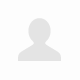
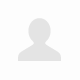

In [41]:
get('https://mail.naver.com', headers=headers, cookies=cookies).text

In [15]:
get('https://mail.naver.com', headers=headers).headers.keys()

KeysView({'Server': 'nginx', 'Date': 'Mon, 03 Oct 2022 09:47:25 GMT', 'Content-Type': 'text/html;charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'Cache-Control': 'no-cache, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'now, -1', 'Pragma': 'no-cache', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=15768000', 'Content-Security-Policy-Report-Only': "script-src 'nonce-58DinRBOz7oHUa5ri7uOvRq2' *.nid.naver.com ssl.pstatic.net 'self'; img-src tivan.naver.com 'self' data: ssl.pstatic.net phinf.pstatic.net ndevthumb-phinf.pstatic.net sp.naver.com static.nid.naver.com lcs.naver.com cc.naver.com soundcaptcha.nid.naver.com captcha.nid.naver.com; media-src 'self' soundcaptcha.nid.naver.com captcha.nid.naver.com; object-src 'self' soundcaptcha.nid.naver.com ; report-uri https://nid.naver.com/login/api/csp.repo.naver.only;", 'Content-Security-Policy': "script-src 'nonce-58DinRBOz7oHUa5ri7uOv

In [57]:
for k, v in cookies.items():
    session.cookies.set(k,v)

In [58]:
session.cookies

<RequestsCookieJar[Cookie(version=0, name='NID_AUT', value='5UpwjW/ywniu4uq7+VktbLayA7UWEcmPZYX5ddrUKmIIAk3KpfT5PJbNISeF0iH0', port=None, port_specified=False, domain='', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False), Cookie(version=0, name='NID_JKL', value='B2KCyKl6PJlmvh1I6LyKxMzo1VGmW9a8nmFT5kuXgRI=', port=None, port_specified=False, domain='', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=None, discard=True, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False), Cookie(version=0, name='NID_SES', value='AAABc8lD45fzY+7h8F+nK+/P3PT0OW+VLugFd70moyfX3zv+XMUezq/3UbM43+aAFi2PuHD+EcGhRAKKfmAOFqefJi2imncSC5b6asdjs8BpHyWZyFUbWFl/vq6gNa9addlUIPpmBq7NnduH/Rm/q5LExQJSlFB3MIHkZfxBE3YE6OcUaI4pQp1/DjGMdwIHKo8CVLXMapfhVZU7tODa7ExeLqm6CJtNnTaRLN3Ec/YHrSqW3YOxh9VgG3pEkKO4Kgk+8QH7

'\n\n\n<!DOCTYPE HTML>\n\n\t\n\t\n\t\n\t\n\t\n\t\t<html lang="ko">\n\t\n\n\n<head>\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n\t\n\t\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail2_le.min.220427.css">\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_skin.min.220427.css">\n\t\t\t\t\n\t\t\t\t\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n\t\t\t\t<link rel="dns-prefetch" href="//ssl.pstatic.net" />\n\t\t\t\t<link rel="dns-prefetch" href="//lcs.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//cc.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//static.nid.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//phinf.pstatic.net" />\n\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_me.min.220427.css">\n\t\t\n\t\n\t<link rel="shortcut icon" href="/favicon.ico?2">\n\t\n\t\n\t\t\n\t\n\t<title>네이버 메일</title>\n\t<script type="text/jav
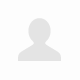
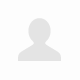

In [59]:
session.get('https://mail.naver.com', headers=headers).text

In [32]:
dom = BeautifulSoup(get('https://search.kyobobook.co.kr/web/search?vPstrKeyWord=%25ED%2595%259C%25EC%25A7%2580%25EB%25AF%25BC&orderClick=LEA').text, 'html.parser')

In [33]:
dom.select('.title a strong')

[<strong>예비 초등학생을 위한 든든한 수학 짝꿍</strong>,
 <strong> 외우지 않고 구구단이 술술술</strong>,
 <strong> 혼잣말</strong>,
 <strong>한 권으로 끝내는 초등 수학사전</strong>,
 <strong> 엄지 척! 초등 수학 사전</strong>,
 <strong> 국어과 수업실연·나눔</strong>,
 <strong> Hello(헬로) 타이베이</strong>,
 <strong> 틈날 때마다 수학 퀴즈</strong>,
 <strong> 비밀경찰 야시</strong>,
 <strong> 봄밤 1</strong>,
 <strong> 봄밤 2</strong>,
 <strong>무적의 낙하산 요원 [SBS 드라마 스페셜]</strong>,
 <strong> 혼잣말</strong>,
 <strong> 뜨인돌어린이/한권으로 끝내는 초등 수학사전+노빈손의 한줄 영어일기 세트(전2권)</strong>,
 <strong> 든든한 수학 짝꿍</strong>,
 <strong>스토리디자인 어린이 작가 그림책 슈퍼걸</strong>,
 <strong> 틈날 때마다 수학 퀴즈</strong>,
 <strong> 외우지 않고 구구단이 술술술</strong>,
 <strong> 엄지 척! 초등 수학 사전</strong>,
 <strong> 봄밤. 1</strong>,
 <strong>든든한 수학 짝꿍</strong>,
 <strong>외우지 않고 구구단이 술술술</strong>,
 <strong>혼잣말</strong>,
 <strong>초등 수학사전</strong>,
 <strong>엄지 척! 초등 수학 사전</strong>,
 <strong>국어과 수업실연·나눔</strong>,
 <strong>Hello(헬로) 타이베이</strong>,
 <strong>틈날 때마다 수학 퀴즈</strong>,
 <strong>비밀경찰 야시</strong>,
 <strong>봄밤 1</strong>,
 <strong>봄밤 2</stro

In [ ]:
받은메일함(제목,내용) 가져오기 => 아침(GET+POST)

In [70]:
c = '''
nid_buk	M6HCEENNVQ5GG	.nid.naver.com	/	2023-11-07T09:35:23.594Z	20		✓				Medium	
NID_JKL	B2KCyKl6PJlmvh1I6LyKxMzo1VGmW9a8nmFT5kuXgRI=	.naver.com	/	Session	51		✓				Medium	
NMUSER	urnlKqEwaqbsKxu/FoMXbreo16e8bq29aqurFotXaAvXKovsFxuZKAnmaqns3xndFoUdFAusHoKma9vsxonOaxRpa9vs6xRpaqRVaqns1rejL9Us6xRVaqnD16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKARqp6FTW43CbNvR16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKAn=	mail.naver.com	/	Session	210						Medium	
NID_SES	AAABdpp+xzLIoakaap1gP5hlq2fHEesBMSz7ql8IQ8Ty8gOBBSHcrHZjYd0z2RCTKiEoCwF8S3mkOaoR1Zhk/W3vE5Sb4cqwDsRmXNY+h1kBSTiMz22sXB1jHTIstKL0hhcV7om+cESmFyEUm1RGi6U4BAnsqp+sDAC9pyFe/oX8xnnpzE9rIUFTZ/vbBkAZC2ZVkJPexjFnY53lRTPT+v2Nt+nWM+Jed85SivPRs7HZ9OEK5j8niDWqZa/6FnZBssW+01EgGXez8BZZIt3pSMScAhmRV5PAnNbAF9RKVebrJTnMWQ2wGLwmDWMR452Hrp3+7fCeIUn+vqJiz07RrEwWyzrll8p86kPwt4UH2ClBb6oMZ/3BTwCYhnFj53iGFab8ccv2AUzCJXb0boHu0DBpj+OIlX+KBMvW/KmMAGgXjKriC0XFeCeNrmuHqFc1VUycswI4g7ObiQrWW8v94C/KISqop4I2rLfrOtsl6tvyfTSJBxlcWsfjckWMkkYqdSYQ5w==	.naver.com	/	Session	527						Medium	
NID_AUT	5UpwjW/ywniu4uq7+VktbLayA7UWEcmPZYX5ddrUKmIIAk3KpfT5PJbNISeF0iH0	.naver.com	/	Session	71	✓					Medium	
nid_slevel	1	.nid.naver.com	/	2023-10-03T09:35:23.000Z	11						Medium	
nid_inf	1514208076	.naver.com	/	Session	17						Medium	
NNB	M6HCEENNVQ5GG	.naver.com	/	2023-11-07T09:58:46.780Z	16		✓	None			Medium	
'''
s = {_.split('\t')[0]:_.split('\t')[1]
     for _ in c.splitlines()
     if len(_) > 0}

In [74]:
s

{'nid_buk': 'M6HCEENNVQ5GG',
 'NID_JKL': 'B2KCyKl6PJlmvh1I6LyKxMzo1VGmW9a8nmFT5kuXgRI=',
 'NMUSER': 'urnlKqEwaqbsKxu/FoMXbreo16e8bq29aqurFotXaAvXKovsFxuZKAnmaqns3xndFoUdFAusHoKma9vsxonOaxRpa9vs6xRpaqRVaqns1rejL9Us6xRVaqnD16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKARqp6FTW43CbNvR16lvpB2RFLl5WLl5MBp0bSloWrdnaAvmKAn=',
 'NID_SES': 'AAABdpp+xzLIoakaap1gP5hlq2fHEesBMSz7ql8IQ8Ty8gOBBSHcrHZjYd0z2RCTKiEoCwF8S3mkOaoR1Zhk/W3vE5Sb4cqwDsRmXNY+h1kBSTiMz22sXB1jHTIstKL0hhcV7om+cESmFyEUm1RGi6U4BAnsqp+sDAC9pyFe/oX8xnnpzE9rIUFTZ/vbBkAZC2ZVkJPexjFnY53lRTPT+v2Nt+nWM+Jed85SivPRs7HZ9OEK5j8niDWqZa/6FnZBssW+01EgGXez8BZZIt3pSMScAhmRV5PAnNbAF9RKVebrJTnMWQ2wGLwmDWMR452Hrp3+7fCeIUn+vqJiz07RrEwWyzrll8p86kPwt4UH2ClBb6oMZ/3BTwCYhnFj53iGFab8ccv2AUzCJXb0boHu0DBpj+OIlX+KBMvW/KmMAGgXjKriC0XFeCeNrmuHqFc1VUycswI4g7ObiQrWW8v94C/KISqop4I2rLfrOtsl6tvyfTSJBxlcWsfjckWMkkYqdSYQ5w==',
 'NID_AUT': '5UpwjW/ywniu4uq7+VktbLayA7UWEcmPZYX5ddrUKmIIAk3KpfT5PJbNISeF0iH0',
 'nid_slevel': '1',
 'nid_inf': '1514208076',
 'NNB': 'M6HCEENNVQ5GG'}

In [71]:
session = Session()
for k,v in s.items():
    session.cookies.set(k,v)

'\n\n\n<!DOCTYPE HTML>\n\n\t\n\t\n\t\n\t\n\t\n\t\t<html lang="ko">\n\t\n\n\n<head>\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n\t\n\t\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail2_le.min.220427.css">\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_skin.min.220427.css">\n\t\t\t\t\n\t\t\t\t\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\t\t\n\t\t\t\t<link rel="dns-prefetch" href="//ssl.pstatic.net" />\n\t\t\t\t<link rel="dns-prefetch" href="//lcs.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//cc.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//static.nid.naver.com" />\n\t\t\t\t<link rel="dns-prefetch" href="//phinf.pstatic.net" />\n\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_me.min.220427.css">\n\t\t\n\t\n\t<link rel="shortcut icon" href="/favicon.ico?2">\n\t\n\t\n\t\t\n\t\n\t<title>네이버 메일</title>\n\t<script type="text/jav
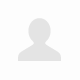
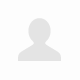

In [78]:
session.get('https://mail.naver.com').text

In [97]:
from requests.compat import urlencode
url = 'https://mail.naver.com/json/list/'
params = {
    'page':1,
    'sortField':1,
    'sortType':0,
    'folderSN':5,
    'type':'',
    'isUnread':'false',
    'u':'sociojs85'
}
# 0->받은메일함, 5->스팸메일함, ...
# 'u' 본인 아이디
resp = session.post(url+'?'+urlencode(params), headers=headers)

In [83]:
resp.headers['content-type']

'text/plain;charset=UTF-8'

In [95]:
mailUrl = 'https://mail.naver.com/json/read/'
mailParams = {
    'charset':'',
    'prevNextMail':'true',
    'threadMail':'true',
    'folderSN':5,
    'listScrollPosition':0,
    'mailSN':0,
    'previewMode':2,
    'u':'sociojs85'
}

In [98]:
for mail in resp.json()['mailData']:
    print(mail['mailSN'], mail['subject'])
    mailParams['mailSN'] = mail['mailSN']
    data = session.post(mailUrl+'?'+urlencode(mailParams), headers=headers)
    body = BeautifulSoup(data.json()['mailInfo']['body'], 'html.parser').text.strip()
    print(body)

4835 [대한민국 4차산업혁명 페스티벌 2022] 드.디.어! 공개된 모든 컨퍼런스 프로그램 및 연사 LIST! 전시와 컨퍼런스 두마리 토끼 모두 놓치지 마세요 (๑•̀ㅂ•́)و✧
If you don't want this type of information or e-mail, please click the [unsubscription]
 Email : nicexpo@ecomice.com
4834 [KMF&amp;KME2022] 역대 최대 규모인 150개사, 350부스로 진행되는 과기부 주최의 KMF&amp;KME 2022!! 10/13(목)~15(토), 3일 동안 다양한 비즈행사와 함께 풍성한 볼거리를 경험하세요:)
If you don't want this type of information or e-mail, please click the [unsubscription]
 Email : k-metaverse@ecomice.com


In [ ]:
# Instagram(로그인)
# 게시물 긁어오기

In [128]:
url = 'https://www.instagram.com/accounts/login/ajax/'
params = {
    'enc_password': '#PWD_INSTAGRAM_BROWSER:10:1664795107:AWNQAPr1+opps4vvJlSuW9LfKFk4pD1+arZP9CptQ3YL0v0ejXs82pFwpuwqT31V5Dp88vjD65YSzLCJj6DRVRJQevx44LEqDYzkBbGlbvHdHLzE4bG4ZqH3SUatSHfZYjqic4Abm926Z2hTtg==',
    'username': 'jjongjong4+dev@gmail.com',
    'queryParams': {},
    'optIntoOneTap': 'false',
    'stopDeletionNonce': '',
    'trustedDeviceRecords': {},
}
headers={'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

In [129]:
from datetime import datetime
url = 'https://www.instagram.com/accounts/login/ajax/'
params = {
    'enc_password': None,
    'username': None,
    'optIntoOneTap': 'false'
}
params['username'] = 'developer_ACDD'
params['enc_password'] = '#PWD_INSTAGRAM_BROWSER:0:{}:{}'.format(int(datetime.now().timestamp()), 'helloworldfromKorea')

headers['x-csrftoken'] = session.cookies.get('csrftoken')

resp = session.post(url, data = params, headers = headers)
resp.status_code

200

In [130]:
resp.text

'{"authenticated":true,"status":"ok"}'

In [ ]:
from selenium.webdriver import Chrome

In [ ]:
# chromedriver => 내 크롬 버전과 동일한 다운로드(압축만풀고)
driver = Chrome(r'C:\Users\Downloads\chromedriver.exe')
# 창이 뜨면, 닫지 마세요

In [ ]:
driver.get('https://www.naver.com'

In [ ]:
from selenium.webdriver.common.by import By
# driver.find_element()
# /, //, .
# /(루트)/
# 

In [ ]:
# RE, DOM(FIND~), XML-XPATH, CSS Selector
driver.find_element(By.XPATH, '//body//div[@id="account"]//a').click()

In [ ]:
for _ in driver.find_elements(By.XPATH,
    '//ul[@class="panel_wrap"]//input[@class="input_text"]'):
    print(_.tag_name, _.get_attribute('id'))

In [ ]:
driver.find_element(By.XPATH, '//input[@id="id"]').send_keys('test')

In [ ]:
session = Session()
for _ in driver.get_cookies():
    session.cookies.set(_['name'], _['value'])

In [ ]:
session.get('https://mail.naver.com').text

In [ ]:
driver.close()

In [ ]:
driver = Chrome()

In [ ]:
for k, v in session.cookies.get_dict().items():
    driver.add_cookie({'name':k,'value':v})

In [ ]:
driver.find_element(
    By.CSS_SELECTOR, '#gnb_name2 + .gnb_btn_login').click()

In [ ]:
Wait=>Explicitly,Imlicitly
Exp->특정 태그
Imp->무조건 기다리기(최대 ~초)

In [ ]:
# driver.implicitly_wait(10)

In [ ]:
driver.find_element(By.CSS_SELECTOR, '.gnb_btn_login').get_attribute('href')

In [ ]:
driver.window_handles

In [ ]:
# (#gnb_my_layer).click()
driver.find_element(By.CSS_SELECTOR, '#gnb_my_layer').click()

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions

In [ ]:
wait = WebDriverWait(driver, timeout=10)

In [ ]:
wait.until(expected_conditions.element_to_be_clickable(
    driver.find_element(By.CSS_SELECTOR, '#gnb_my_layer')))
# wait.until_not()

In [ ]:
driver.window_handles

In [ ]:
driver.get('https://www.naver.com')

In [ ]:
driver.switch_to.window(driver.window_handles[2])

In [ ]:
iframe = driver.find_element(By.CSS_SELECTOR, '#mainFrame')

In [ ]:
driver.switch_to.frame(iframe)

In [ ]:
driver.find_element(By.CSS_SELECTOR, 'body').text

In [ ]:
driver.switch_to.default_content()

In [ ]:
Selenium -> 자동화(for testing), 수집도구로써 사용가능
Xpath
painting(displying) - Exp(특정 태그). Imp(document 전체). wait
                    => 네이버 로그아웃 버튼
창 전환, DOM(iframe) 전환
swith_to.~ DOM
JS해석, DDOS => Cookie

In [ ]:
BeautifulSoup(driver.page_source, 'html.parser')

In [ ]:
driver.execute_script('alert(a)')